In [ ]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095435 sha256=744115c55effa9ba03c93a24226605e93dc1a61dfdc1a8bc0a7e4a1561fc3894
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import math
import re
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
from cvxpy import *
from numpy import matrix
class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            #if (i+1) % 100 == 0:
            #    print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [ ]:
#Setting up prerequisites
#from numba import prange
import pandas as pd
import numpy as np
import math
import re
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
from cvxpy import *
print("Setup Complete\n")


Setup Complete



In [ ]:
import pandas as pd
print("Select Number of DataPoints to Train on: \n1: 1024 \t2: 10000 \n3: 25000 \t4: 75000 \n5: 100000 \t6: 200000\n\n")
choice = int(input())
print("\nLoading Data\n")
if (choice==1 or choice==1024):
	df1 = pd.read_csv('feasible_data_1024.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'], usecols = [0,1,2])
elif (choice==2 or choice==10000):
	df1 = pd.read_csv('feasible_data_10000.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'], usecols = [0,1,2])
elif (choice==3 or choice==25000):
	df1 = pd.read_csv('feasible_data_25000.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'], usecols = [0,1,2])
elif (choice==4 or choice==75000):
	df1 = pd.read_csv('feasible_data_75000.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'], usecols = [0,1,2])
elif (choice==5 or choice==100000):
	df1 = pd.read_csv('feasible_data_100000.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'], usecols = [0,1,2])
elif (choice==6 or choice==200000):
	df1 = pd.read_csv('feasible_data_200000.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'], usecols = [0,1,2])

Select Number of DataPoints to Train on: 
1: 1024 	2: 10000 
3: 25000 	4: 75000 
5: 100000 	6: 200000


3

Loading Data



In [ ]:
df1['Rating'] = df1['Rating'].astype(float)
df1['Date'] = df1['Date'].astype(str)
df1['Date'] = df1['Date'].map( lambda s : (s[:4])+(s[5:7])+(s[8:]))
df1['Date'] = df1['Date'].astype(float)
print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::10000, :])
#print(df1['Date'].dtype)
df = df1


Dataset 1 shape: (25000, 3)
-Dataset examples-
       Cust_Id  Rating        Date
0           1:     NaN         NaN
10000   470361     2.0  20050516.0
20000  1189445     4.0  20050625.0


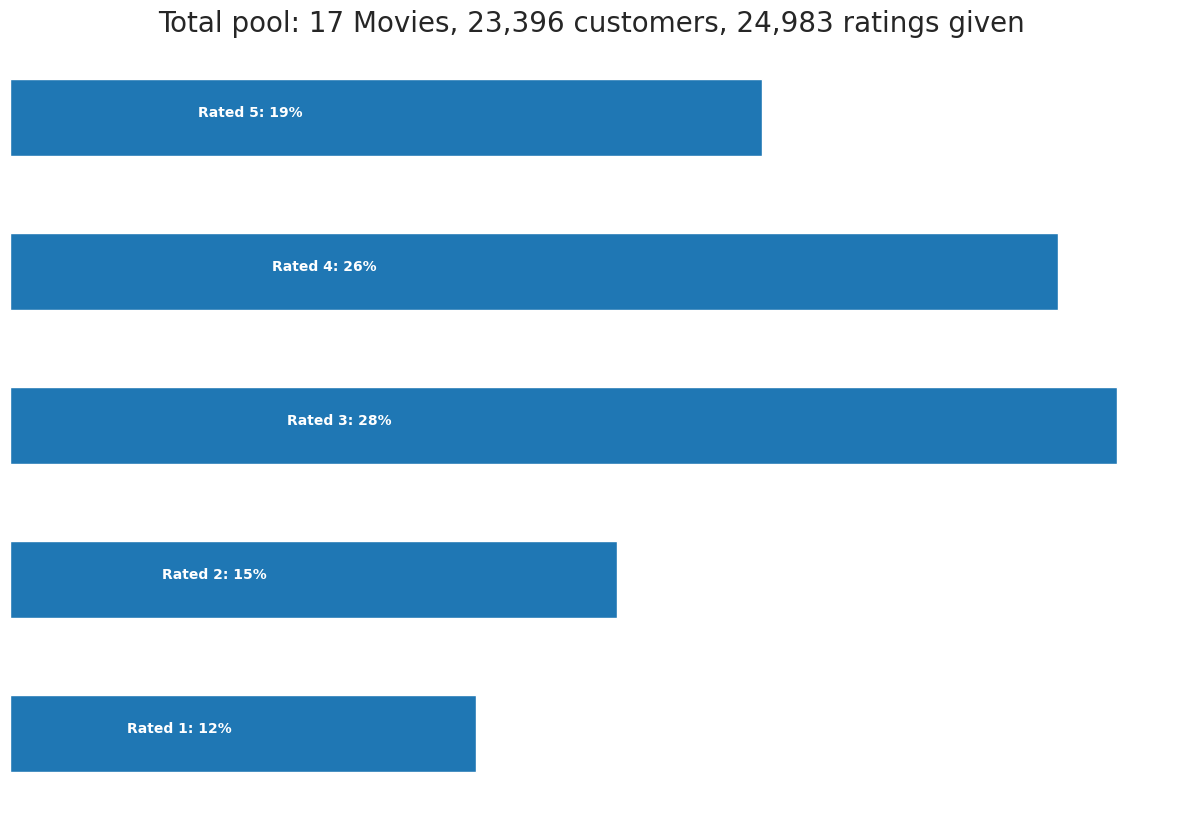

In [ ]:

#Seeing the distribution of ratings given by the users
#print("See Overview of the Data")
import matplotlib.pyplot as plt
p = df.groupby('Rating')['Rating'].agg(['count'])
# get movie count
movie_count = df.isnull().sum()[1]
# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count
# get rating count
rating_count = df['Cust_Id'].count() - movie_count
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rated {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


In [ ]:


import numpy as np
#Adding movie IDs to the dataset
print("\nExtracting Movie IDs\n")
movie_np = []
movie_id = 0
for x in range(df.shape[0]):
    if(np.isnan(df.iloc[x]['Rating'])):
        movie_id = movie_id+1
    movie_np = np.append(movie_np,movie_id)
#print(movie_np)
#print(len(movie_np))
df['Movie_Id'] = movie_np.astype(int)
print("Movie IDs extracted from the extra rows given")





Extracting Movie IDs

Movie IDs extracted from the extra rows given


In [ ]:
 # remove the extra Movie ID rows
print("\nRemoving extra Movie ID rows\n")
df = df[pd.notnull(df['Rating'])]
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::100, :])
print("\n\nThese are the final datatypes of the dataset")
print(df.dtypes)




Removing extra Movie ID rows

-Dataset examples-
       Cust_Id  Rating        Date  Movie_Id
1      1488844     3.0  20050906.0         1
101    1155747     3.0  20050703.0         1
201    1141189     4.0  20041215.0         1
301    2256485     1.0  20040819.0         1
401    2322840     3.0  20050712.0         1
...        ...     ...         ...       ...
24517   509786     3.0  20050811.0        17
24617   429038     4.0  20051020.0        17
24717   421130     2.0  20050829.0        17
24817  1523984     1.0  20050714.0        17
24917   327993     4.0  20051102.0        17

[250 rows x 4 columns]


These are the final datatypes of the dataset
Cust_Id       int64
Rating      float64
Date        float64
Movie_Id      int64
dtype: object


<ipython-input-9-28c47e94b145>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


In [ ]:
#Creating Data Matrix
df_matrix=pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_matrix.shape)


(23396, 17)


In [ ]:
#Loading the Movie ID- Movie Title Mapping File
print("\nLoading the Movie ID- Movie Title Mapping File\n")
df_title = pd.read_csv('movie_titles (2).csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print("See some Movie ID- Movie Title Mapping : \n")
print (df_title.head(8))


Loading the Movie ID- Movie Title Mapping File

See some Movie ID- Movie Title Mapping : 

            Year                          Name
Movie_Id                                      
ï»¿1      2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?


In [ ]:
print("\n\nData Cleaning Complete.\n See head of the Data Matrix:\n")
print(df_matrix.head())
n_movies = movie_count
n_customers = cust_count
print("\nNum of movies =", movie_count)
print("Num of users =", cust_count)
print()



Data Cleaning Complete.
 See head of the Data Matrix:

Movie_Id  1   2   3   4    5   6   7    8   9   10  11  12  13  14  15  16  17
Cust_Id                                                                       
7        NaN NaN NaN NaN  NaN NaN NaN  5.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN
307      NaN NaN NaN NaN  NaN NaN NaN  3.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN
685      NaN NaN NaN NaN  3.0 NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
695      NaN NaN NaN NaN  NaN NaN NaN  1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN
734      NaN NaN NaN NaN  NaN NaN NaN  1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN

Num of movies = 17
Num of users = 23396



In [ ]:
#Choosing the number of latent attributes
n_attr= 100*50
#print(type(n_attr),type(n_movies), type(n_customers))
Q = Variable((n_attr,n_movies))
P = Variable((n_attr, n_customers))
acq_data = df_matrix.fillna(0.0)
print(acq_data.head())


Movie_Id   1    2    3    4    5    6    7    8    9    10   11   12   13  \
Cust_Id                                                                     
7         0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0   
307       0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0   
685       0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
695       0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
734       0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

Movie_Id   14   15   16   17  
Cust_Id                       
7         0.0  0.0  0.0  0.0  
307       0.0  0.0  0.0  0.0  
685       0.0  0.0  0.0  0.0  
695       0.0  0.0  0.0  0.0  
734       0.0  0.0  0.0  0.0  



Randomly Distributing Test and Train Set by removing 20% values...

Done

Original:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Test Set:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
RMSE= 0.37463420689184224

Training ...


Done

Minimizing Error on Training Set:

Learnt=
 [[4.43908429 3.762442   4.48376621 ... 5.03511196 4.03546024 3.14025169]
 [4.24300166 4.37842942 3.67081243 ... 2.47029296 3.02930102 3.31461005]
 [3.19343234 3.37036363 3.04654602 ... 2.55120559 2.48564316 2.4665199 ]
 ...
 [3.464594   3.19905095 3.91940108 ... 4.84060889 3.5163726  2.64196176]
 [4.69524594 5.60054246 4.53731581 ... 3.41398524 3.91052271 4.51726791]
 [3.79195289 3.82288869 4.08002281 ... 4.46336896 3.61803917 3.12793188]]

Rating predictions=
 [[4. 4. 4. ... 5. 4. 3.]
 [4. 4. 

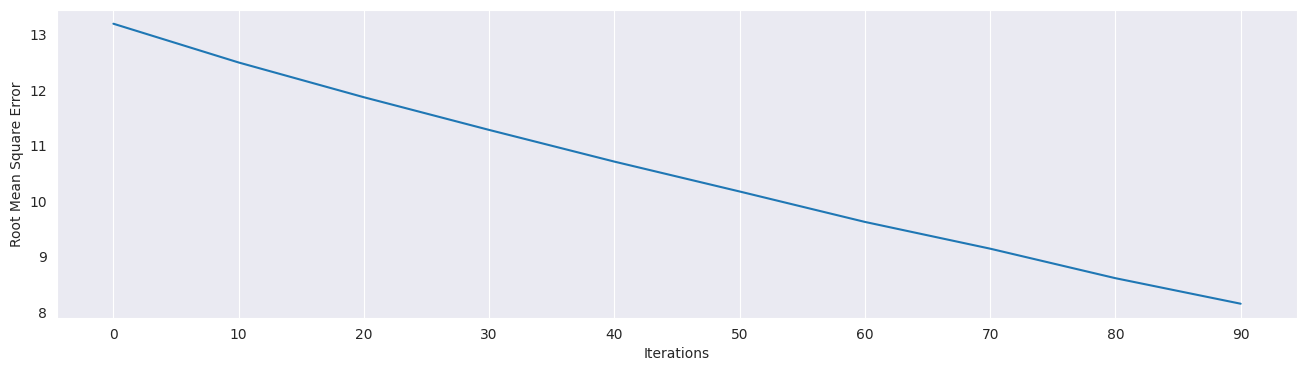

In [ ]:

R = np.array(acq_data)
R1= np.array(acq_data)


print("\nRandomly Distributing Test and Train Set by removing 20% values...\n")
#This cell works on Real DataSet
R = np.array(acq_data)
R1= np.array(acq_data)
#Set the number of values to replace. For example 20%:
prop = int(R.size * 0.2)
#Randomly choose indices of the numpy array:
#print("Creating Random Indices\n")
# i = [np.random.choice(range(R.shape[0])) for _ in range(prop)]
# j = [np.random.choice(range(R.shape[1])) for _ in range(prop)]
i = np.random.randint(0,R.shape[0],size=prop)
j = np.random.randint(0,R.shape[1],size=prop)
#print("Created Random Indices\n")
print("Done\n")
#print("i=",i)
#print("j=",j)
#Change values with 0
R[i,j] = 0
print("Original:\n",R1)
print("Test Set:\n",R)
R=np.rint(R)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(R, R1)
print("RMSE=",mse**0.5)
print("\nTraining ...\n")
mf = MF(R, K=2, alpha=0.01, beta=0.01, iterations=100)
training_process = mf.train()
L=np.rint(mf.full_matrix())
print("\nDone\n")
x = [x for x, y in training_process]
y = [y for x, y in training_process]
x = x[::10]
y = y[::10]
plt.figure(figsize=((16,4)))
plt.plot(x, np.sqrt(y))
plt.xticks(x, x)
print("Minimizing Error on Training Set:\n")
plt.xlabel("Iterations")
plt.ylabel("Root Mean Square Error")
plt.grid(axis="y")
print("Learnt=\n",mf.full_matrix())
print("\nRating predictions=\n",L)
print()
print()
print("Global bias:")
print(mf.b)
print()
print("User bias:")
print(mf.b_u)
print()
print("Item bias:")
print(mf.b_i)
print("\nFinding Error on test set...\n")
msef=0.0
# for i1 in range(len(i)):
#     for i2 in range(len(j)):
#         if R1.item(i[i1],j[i2])!=0:
#             msef = msef + (R1.item((i[i1],j[i2]))-(L).item((i[i1],j[i2])))**2
# msef = (msef/(len(j)*len(i)))
valid_cmp = ~np.isnan(df_matrix)
msef = np.sum(np.sum(np.multiply(valid_cmp,np.square(R1-L)),axis=None))/(len(j)*len(i)*1.00)

print("RMSE final=",msef**0.5)